In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import timm
import numpy as np
import pandas as pd
import os
import sys
import faiss
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Subset
from collections import defaultdict
from sklearn.metrics import silhouette_score
import csv
from pathlib import Path
from matplotlib import pyplot as plt
import random
from PIL import Image
import json

In [2]:
# Defining project paths

project_root = os.path.abspath('.')
if project_root not in sys.path:
    sys.path.append(project_root) 
    
training_eda_path = os.path.join(project_root, "eda_img")
training_data_path = os.path.join(project_root, "PlantCLEF2025_data/images_max_side_800")
inference_data_path = os.path.join(project_root, "PlantCLEF2025_data/test_images/images")

In [63]:
#==============================================
# EDA of training images
#==============================================

# ImageFolder auto loads and organizes images, class names and labels/indices based on folder names and structure
transform = transforms.Compose([
                    transforms.ToTensor(),   # conver image into Pytorch tensors (C, H, W)
                    transforms.CenterCrop(600)   # make each tensor to be equal size, or DataLoader will give error
                    ])

eda_data = datasets.ImageFolder(root=training_eda_path, transform=transform) 

# Inspecting dataset.classes and dataset.class_to_idx
eda_data.classes    # a list of class names (folder names).


['1355869', '1355870', '1355885', '1355886', '1355898', '1355899']

In [64]:
eda_data.class_to_idx    # a dictionary mapping class names (class) to their integer indices/labels (idx).

{'1355869': 0,
 '1355870': 1,
 '1355885': 2,
 '1355886': 3,
 '1355898': 4,
 '1355899': 5}

In [65]:
# image and label are default attributes of dataset created by ImageFolder
for i, (image, label) in enumerate(eda_data):
        print(f"Sample {i}: Image type: {type(image)}, Label: {label}")
        if i >= 17:  # the images in the next folder will be labelled to the next index
            break

Sample 0: Image type: <class 'torch.Tensor'>, Label: 0
Sample 1: Image type: <class 'torch.Tensor'>, Label: 0
Sample 2: Image type: <class 'torch.Tensor'>, Label: 0
Sample 3: Image type: <class 'torch.Tensor'>, Label: 0
Sample 4: Image type: <class 'torch.Tensor'>, Label: 0
Sample 5: Image type: <class 'torch.Tensor'>, Label: 0
Sample 6: Image type: <class 'torch.Tensor'>, Label: 0
Sample 7: Image type: <class 'torch.Tensor'>, Label: 0
Sample 8: Image type: <class 'torch.Tensor'>, Label: 0
Sample 9: Image type: <class 'torch.Tensor'>, Label: 0
Sample 10: Image type: <class 'torch.Tensor'>, Label: 0
Sample 11: Image type: <class 'torch.Tensor'>, Label: 0
Sample 12: Image type: <class 'torch.Tensor'>, Label: 0
Sample 13: Image type: <class 'torch.Tensor'>, Label: 0
Sample 14: Image type: <class 'torch.Tensor'>, Label: 0
Sample 15: Image type: <class 'torch.Tensor'>, Label: 0
Sample 16: Image type: <class 'torch.Tensor'>, Label: 1
Sample 17: Image type: <class 'torch.Tensor'>, Label: 1


Image type: <class 'torch.Tensor'>, Label: 1


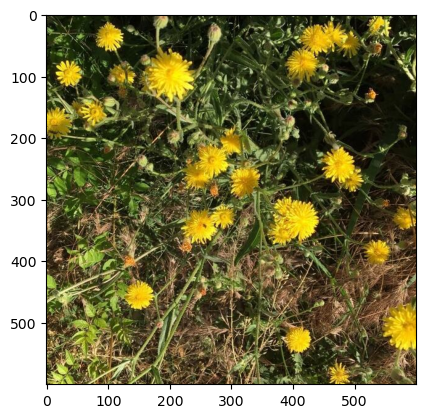

In [66]:
# itemize image and lebel, and display image
image, label = eda_data[17]       # image is in Pytorch tensor format (C, H, W)
print(f"Image type: {type(image)}, Label: {label}")

image_np = image.permute(1, 2, 0).numpy()  # need to convert the Pytorch tensor to a NumPy array
                                           # and transpose it to the (H, W, C) format
plt.imshow(image_np);
#plt.imshow(image)   # can plot directly if image has not been converted to Pytorch tensor


In [67]:
# Create an index-to-name mapping: a reverse mapping from index/label to class name
idx_to_class_mapping = {idx: class_name for class_name, idx in eda_data.class_to_idx.items()}
print(f"Index to class mapping: {idx_to_class_mapping}")

print(f"Image type: {type(image)}, Label/index: {label}, Class/name: {idx_to_class_mapping[label]}")


Index to class mapping: {0: '1355869', 1: '1355870', 2: '1355885', 3: '1355886', 4: '1355898', 5: '1355899'}
Image type: <class 'torch.Tensor'>, Label/index: 1, Class/name: 1355870


In [79]:
# Using DataLoader: for batching and shuffling data.
eda_loader = DataLoader(eda_data, batch_size=2, shuffle=True)

images, labels = next(iter(eda_loader))   # get the first batch
print(f"Batch 1 images shape: {images.shape}")
print(f"Batch 1 labels: {labels}")
print(f"Batch 1 class/folder names: {[idx_to_class_mapping[label] for label in labels.tolist()]}")


Batch 1 images shape: torch.Size([2, 3, 600, 600])
Batch 1 labels: tensor([0, 5])
Batch 1 class/folder names: ['1355869', '1355899']


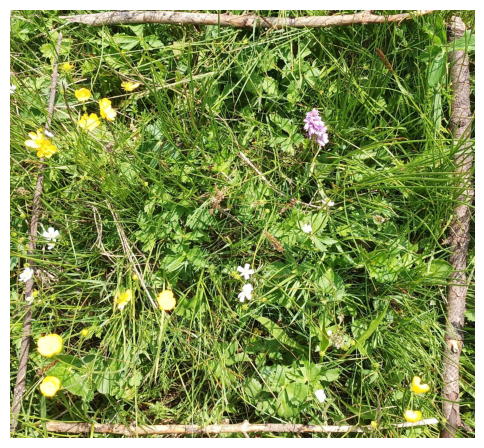

In [21]:
quadrat = Image.open("2024-CEV3-20240602.jpg")
fig, ax = plt.subplots(figsize=(6, 6)) 
ax.imshow(quadrat)
plt.axis('off'); 

In [7]:
def tile_image_nxn(img, tiles_per_side=3, target_size=256):  # no tiling for the inital Baseline 1
    w, h = img.size

    tile_w = w / tiles_per_side
    tile_h = h / tiles_per_side

    tiles = []

    for row in range(tiles_per_side):
        for col in range(tiles_per_side):
            left = int(col * tile_w)
            top = int(row * tile_h)
            right = int((col + 1) * tile_w)
            bottom = int((row + 1) * tile_h)

            tile = img.crop((left, top, right, bottom))
            tile = tile.resize((target_size, target_size), Image.BICUBIC)
            tiles.append(tile)

    return tiles

In [8]:
tiles = tile_image_nxn(quadrat)
len(tiles), tiles[0]

(9, <PIL.Image.Image image mode=RGB size=256x256>)

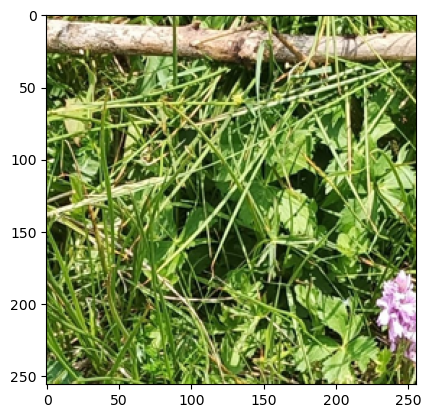

In [16]:
plt.imshow(tiles[1]); 

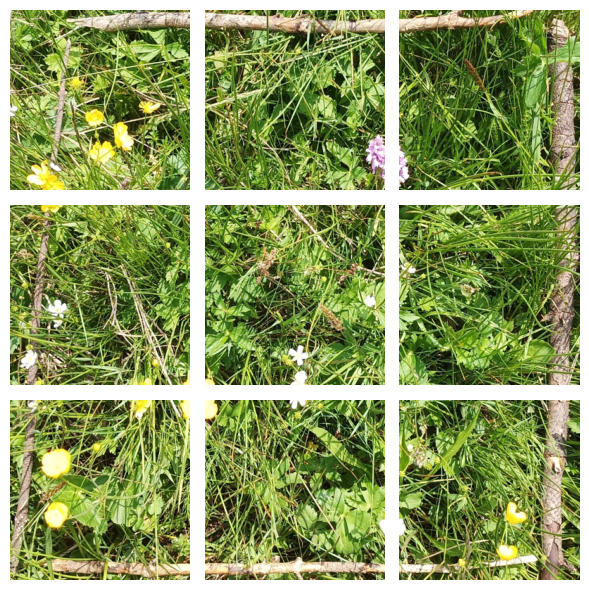

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
axs[0, 0].imshow(tiles[0])
axs[0, 0].axis("off")
axs[0, 1].imshow(tiles[1])
axs[0, 1].axis("off")
axs[0, 2].imshow(tiles[2])
axs[0, 2].axis("off")
axs[1, 0].imshow(tiles[3])
axs[1, 0].axis("off")
axs[1, 1].imshow(tiles[4])
axs[1, 1].axis("off")
axs[1, 2].imshow(tiles[5])
axs[1, 2].axis("off")
axs[2, 0].imshow(tiles[6])
axs[2, 0].axis("off")
axs[2, 1].imshow(tiles[7])
axs[2, 1].axis("off")
axs[2, 2].imshow(tiles[8])
axs[2, 2].axis("off")
plt.tight_layout()
plt.show()
